### ARIMA model forecast

In [1]:
# let's import necassary packages...

%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product


Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


<Figure size 864x432 with 0 Axes>

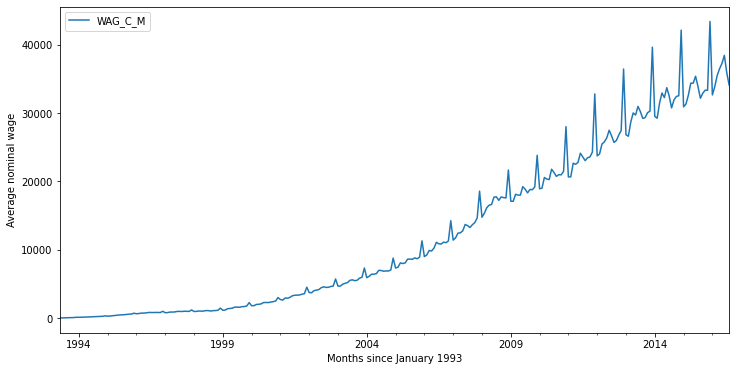

In [3]:
# let's load data...
WAG = pd.read_csv('/content/drive/My Drive/SMLT December 2021/WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251')
plt.figure(figsize(12,6))
WAG.plot()
plt.ylabel('Average nominal wage')
plt.xlabel('Months since January 1993')
pylab.show()

In [4]:
WAG.head(10)
print (WAG.shape)

(280, 1)


Dickey-Fuller test: p=0.991667


<Figure size 1080x720 with 0 Axes>

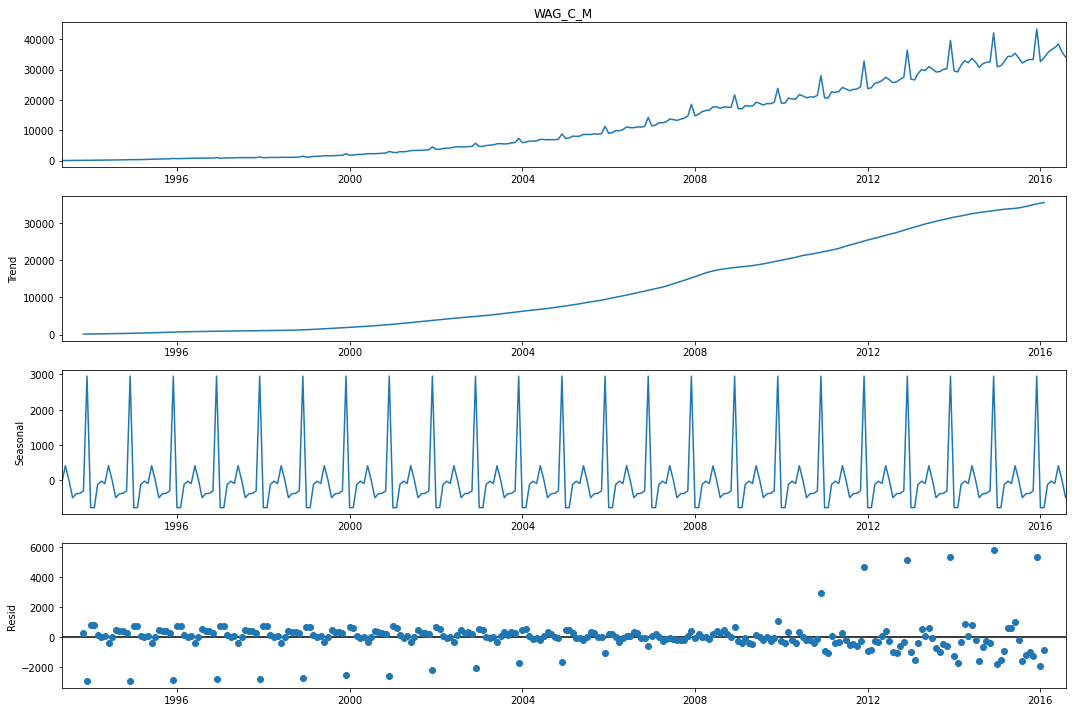

In [5]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M)[1])

Best Box-Cox parameter: 0.257063
Dickey-Fuller test: p=0.688484


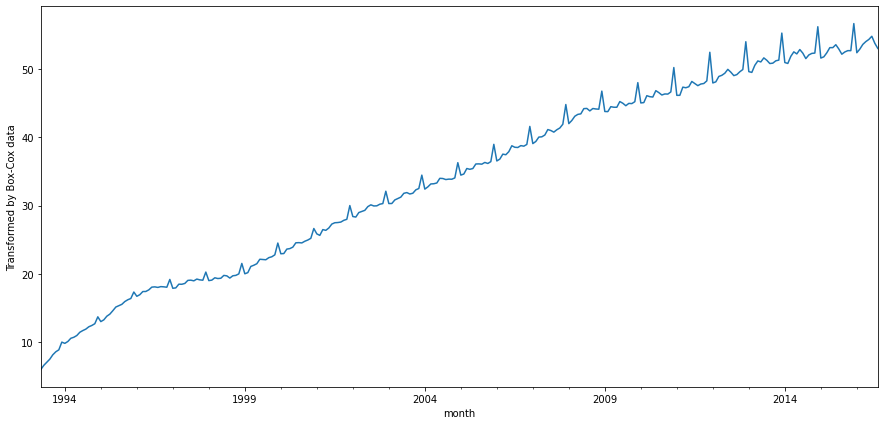

In [6]:
# Box-Cox transformation for dispersion stationarity

WAG['WAG_C_M_box'], lmbda = stats.boxcox(WAG.WAG_C_M)
plt.figure(figsize(15,7))
WAG.WAG_C_M_box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box)[1])

Dickey-Fuller test: p=0.033416


<Figure size 1080x720 with 0 Axes>

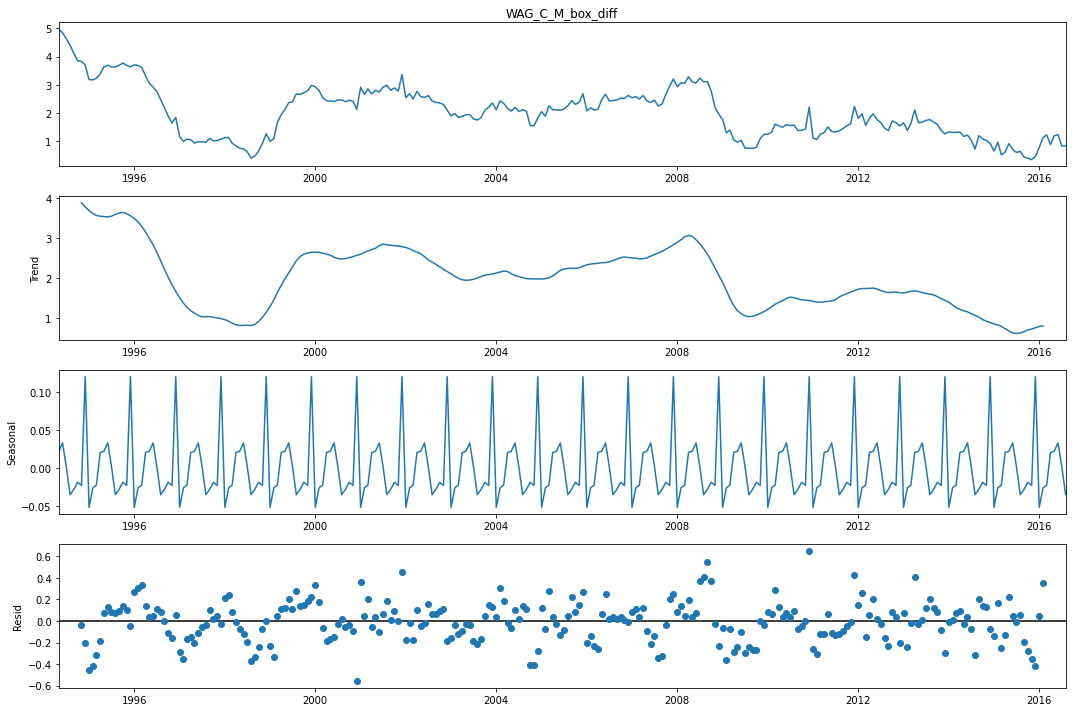

In [7]:
# seasonal difference for 12 months

WAG['WAG_C_M_box_diff'] = WAG.WAG_C_M_box - WAG.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff[12:])[1])

Dickey-Fuller test: p=0.000000791458638


<Figure size 1080x720 with 0 Axes>

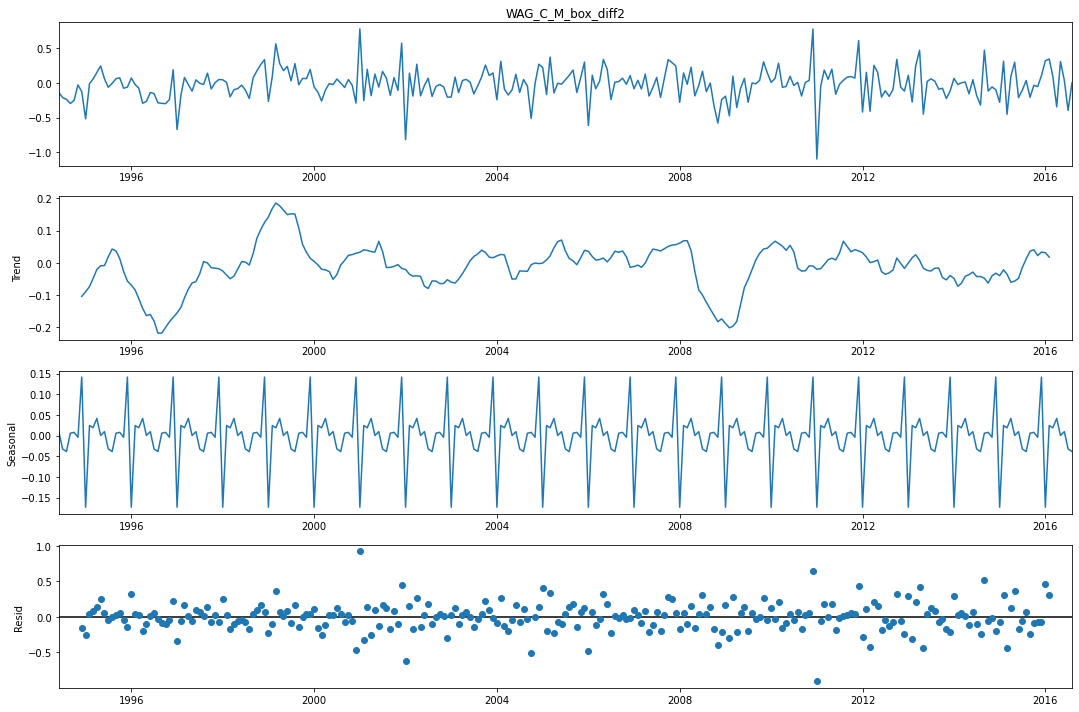

In [8]:
# additional 1-step difference

WAG['WAG_C_M_box_diff2'] = WAG.WAG_C_M_box_diff - WAG.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff2[13:])[1])

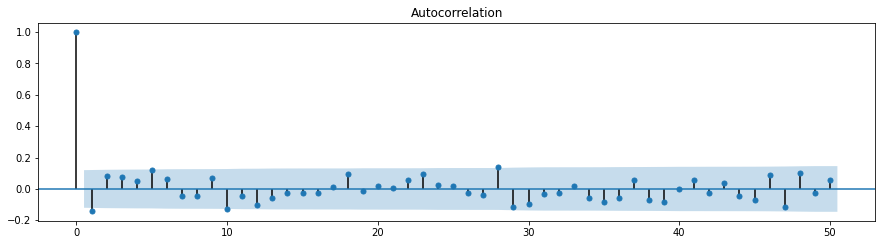

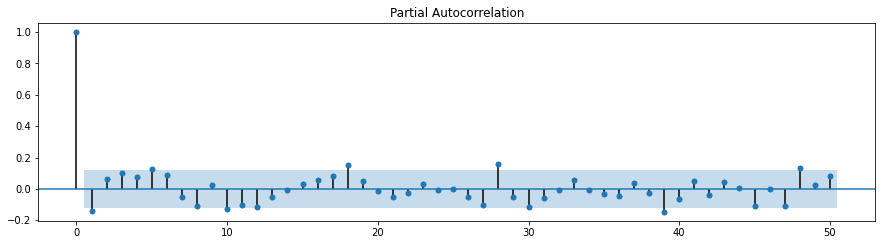

In [9]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [10]:
# parameters for SARIMA model
# better use values < 10
# p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use
# q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use
# d - show how many times have we derivated our series 1-step-wise
# D - show how many times have we derivated our series Period-step-wise

ps = range(0, 6)   # 5 
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [11]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

      parameters        aic
15  (5, 4, 1, 0) -54.644807
14  (4, 5, 1, 0) -52.889030
13  (2, 2, 1, 0) -49.074861
12  (2, 2, 0, 0) -49.021112
11  (1, 5, 1, 0) -43.322848


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
15  (5, 4, 1, 0) -54.644807
14  (4, 5, 1, 0) -52.889030
13  (2, 2, 1, 0) -49.074861
12  (2, 2, 0, 0) -49.021112
11  (1, 5, 1, 0) -43.322848


In [13]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_box   No. Observations:                  280
Model:             SARIMAX(5, 1, 4)x(1, 1, [], 12)   Log Likelihood                  38.322
Date:                             Tue, 06 Sep 2022   AIC                            -54.645
Time:                                     18:22:46   BIC                            -15.185
Sample:                                 05-01-1993   HQIC                           -38.794
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6968      0.055     12.598      0.000       0.588       0.805
ar.L2         -0.4411      

Student test: p=0.237266
Dickey-Fuller test: p=0.0000000000000000000000000


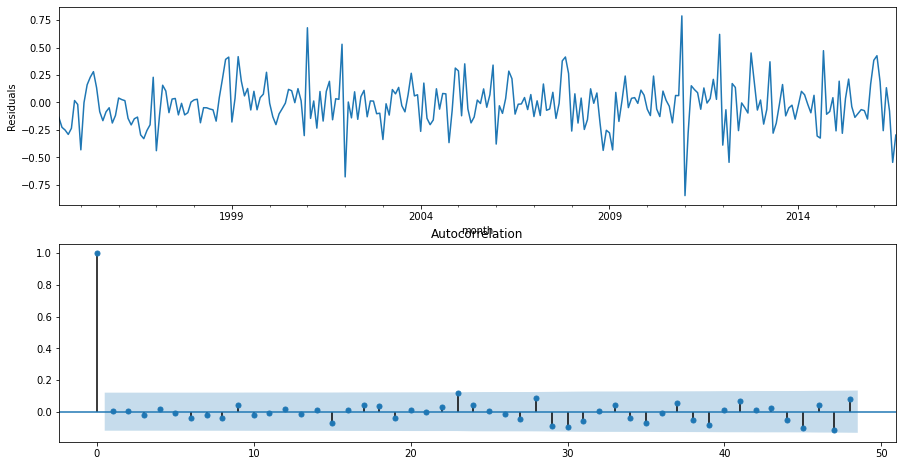

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

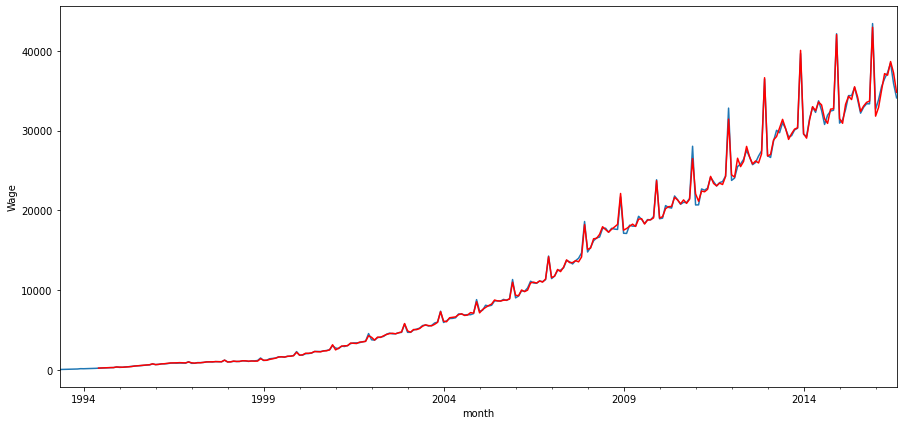

In [15]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
WAG.WAG_C_M.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()



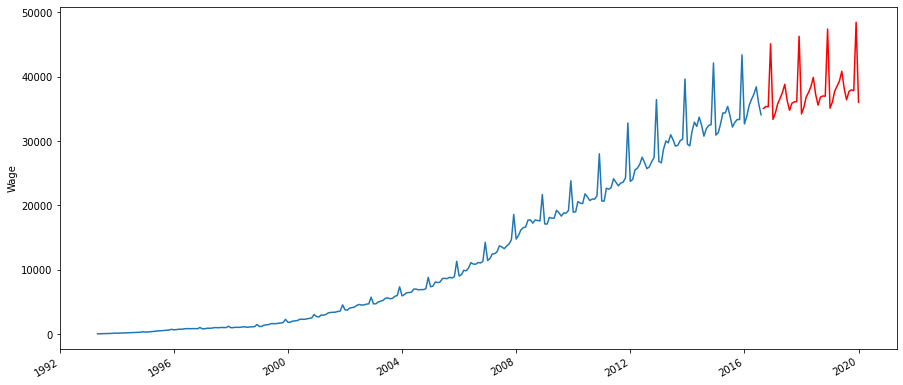

In [16]:
WAG2 = WAG[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(best_model.predict(start=280, end=320), lmbda)

plt.figure(figsize(15,7))
WAG2.WAG_C_M.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()